# StyleCLIP

Редактирование изображений -- очень важная и интересная задача в мире генеративных моделей. В этом ноутбуке мы с вами попробуем решить эту задачу на основе работы [StyleCLIP](https://arxiv.org/abs/2103.17249).

Данный метод позволяет редактировать изображения, сгенерированные [StyleGAN2](https://github.com/rosinality/stylegan2-pytorch), используя текстовые описания. Например, вы можете взять фотографию человека и с помощью текстовой подсказки "сделать волосы кудрявыми" изменить прическу на фотографии. Основная идея данной работы в том, чтобы "подвинуть" изначальный латент так, чтобы сгенерированное из него изображение лучше соответствовало предложенному промпту. Авторы предлагают два основных подхода:

- Оптимизация латентного вектора на основе CLIP Loss

- Обучение специального Mapper для сдвига

Более подробно про эти два подхода можно почитать в самой стате [StyleCLIP](https://arxiv.org/abs/2103.17249).

Мы с вами рассмотрим только одну часть предложенного метода, а именно оптимизацию для редактирования. Как уже было сказано, StyleCLIP оптимизирует латентный вектор [StyleGAN2](https://arxiv.org/abs/1912.04958) для более точного соотвествия заданному промпту.

Идея StyleCLIP с оптимизацией отображена на изображении ниже.




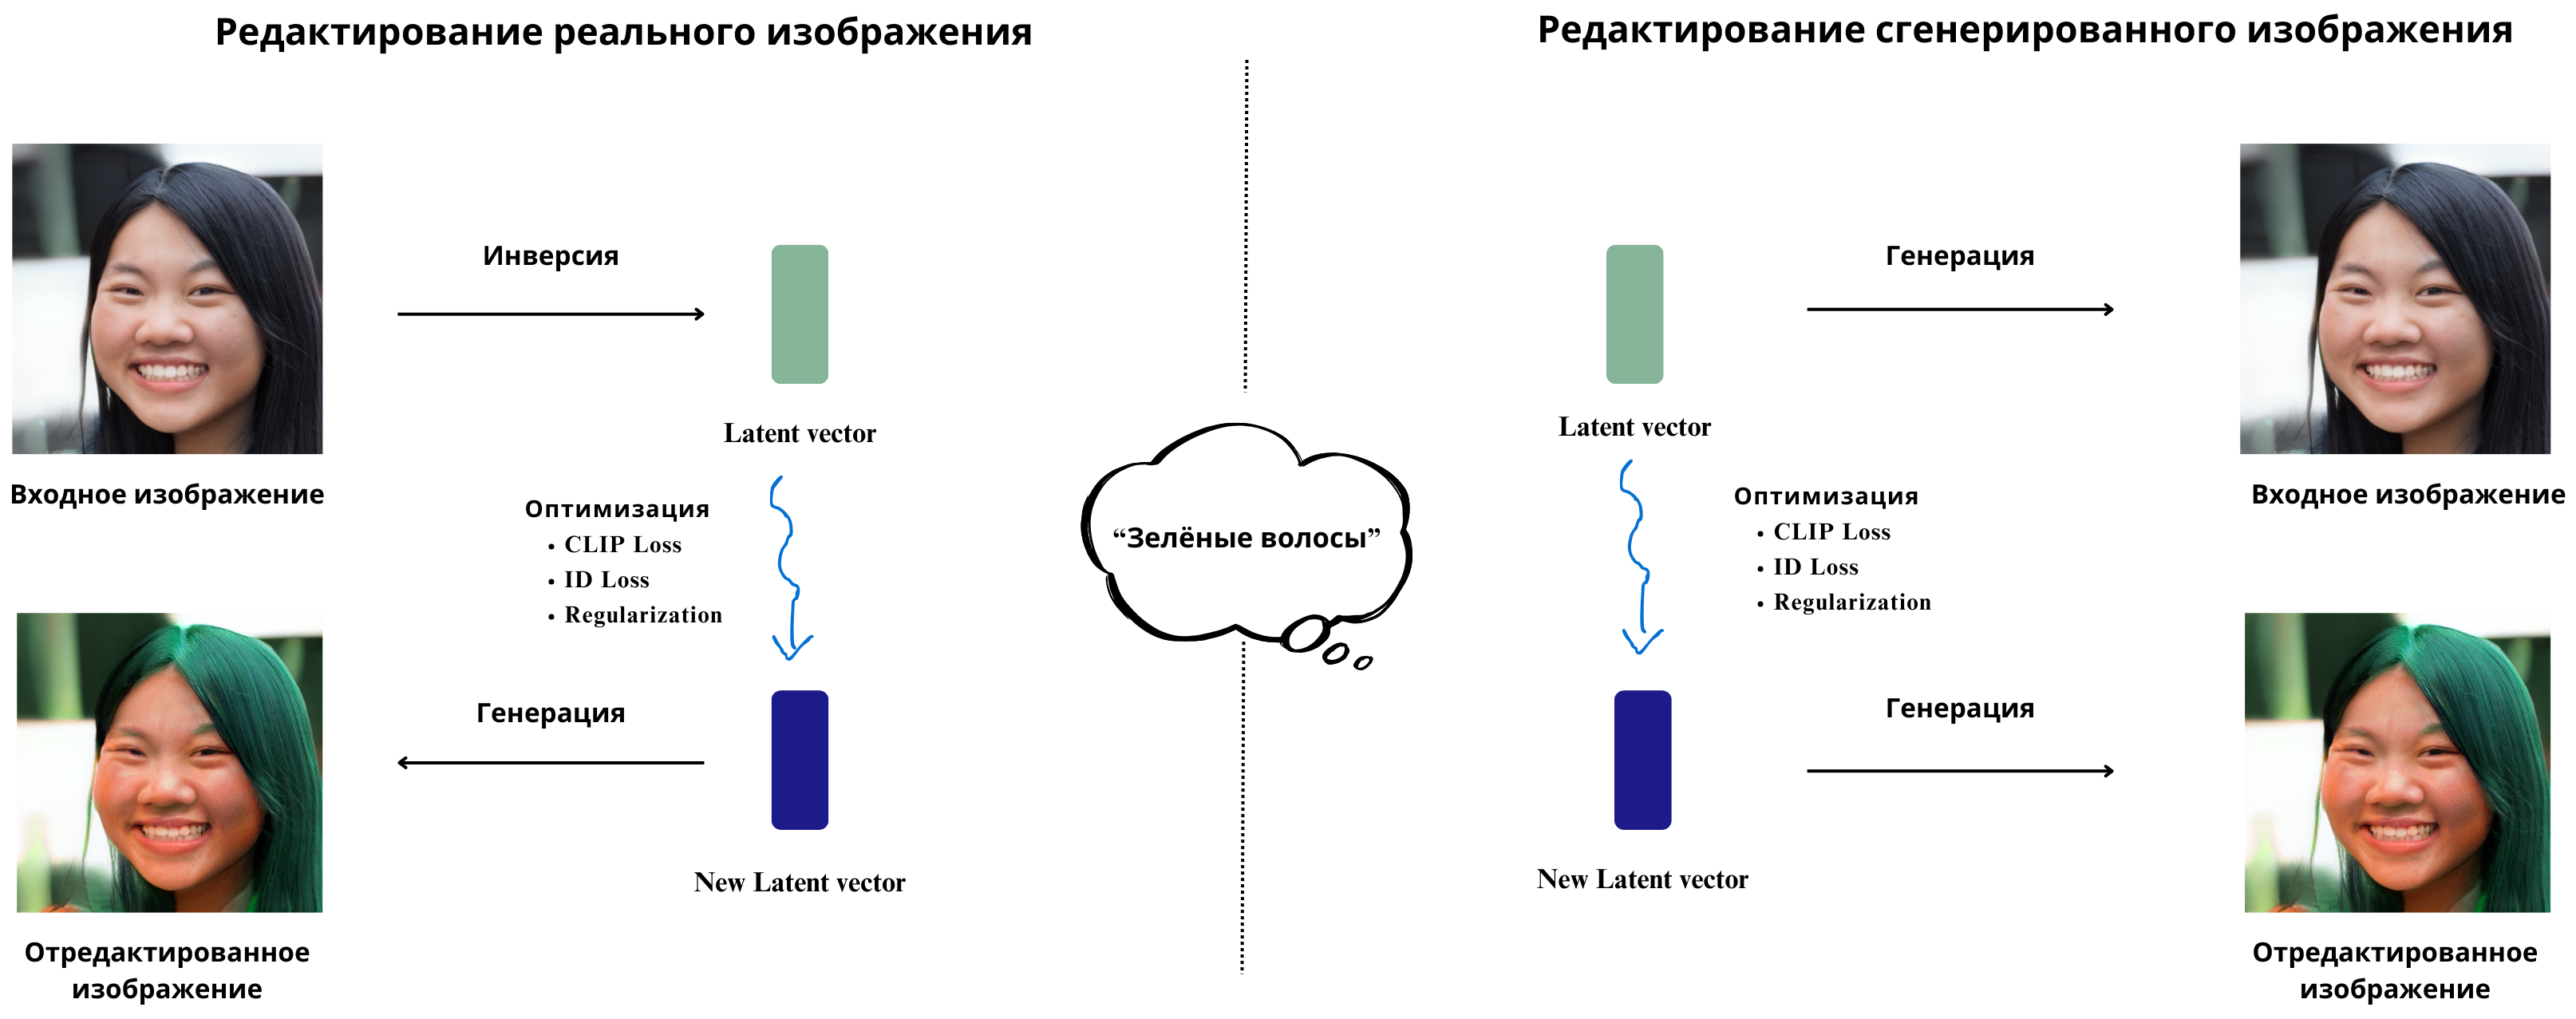

Наш план будет состоять в следующем:

1. Подготовка всех моделей для оптимизации

2. Реализация всех необходимых функций потерь:

  - CLIP Loss (1 балла)
  - ID Loss (1 балла)

3. Подготовка кода оптимизации (2 балла)

4. Выводы из полученных результатов (1 балл)

Давайте же попробуем написать код для этой оптимизации!

## Установка необходимых библиотек и подготовка окружения
Начнем с установки необходимых библиотек и клонирования репозитория StyleCLIP, чтобы использовать его методы.

In [ ]:
# Установка необходимых библиотек

# Установка зависимостей
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git
# Установка дополнительных библиотек
!pip install Ninja

# Импорт нужных библиотек
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.utils import save_image
import clip
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.2 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-0ye929rk
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-0ye929rk
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 49.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 46.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# Клонирование репозитория StyleGAN2
!git clone https://github.com/rosinality/stylegan2-pytorch.git

Cloning into 'stylegan2-pytorch'...
remote: Enumerating objects: 395, done.
remote: Total 395 (delta 0), reused 0 (delta 0), pack-reused 395 (from 1)
Receiving objects: 100% (395/395), 122.51 MiB | 42.89 MiB/s, done.
Resolving deltas: 100% (205/205), done.


In [ ]:
cd stylegan2-pytorch/

/content/stylegan2-pytorch


In [ ]:
# Будем работать с конкретным сидом
torch.manual_seed(345)

## Основная идея статьи


Как уже было сказано, мы хотим редактировать изображение с помощью текста. Для этого будем использовать [CLIP](https://paperswithcode.com/method/clip) модель для некоторого гайданса в процессе оптимизации.

Задачу мы хотим построить следующим образом: имея исходный латентный вектор $w \in W$ мы хотим оптимизировать его под текстовый запрос $t$. Давайте подгрузм нашу модель и сгенерируем картинку для дальнейшей оптимизации.

Для работы со StyleGAN-2 нам для начала нужно скачать модель. Для скачивания мы используем следующий код:

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# downloads StyleGAN's weights and facial recognition network weights
ids = ['1EM87UquaoQmk17Q8d5kYIAHqu0dkYqdT', '1N0MZSqPRJpLfP4mFQCS14ikrVSe8vQlL']
for file_id in ids:
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.FetchMetadata(fetch_all=True)
  downloaded.GetContentFile(downloaded.metadata['title'])

In [ ]:
# Зададим девайс: cuda или cpu
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Зададим сид
seed = 3456
torch.manual_seed(seed)

# Загрузка модели генератора StyleGAN2
from model import Generator
latent_dim = 512
generator = Generator(size=1024, style_dim=latent_dim, n_mlp=8).to(device)
state_dict = torch.load('/content/stylegan2-pytorch/stylegan2-ffhq-config-f.pt', map_location=device)
generator.load_state_dict(state_dict['g_ema'])
generator.eval()

print("Генератор StyleGAN2 загружены.")


/usr/local/lib/python3.11/dist-packages/torch/utils/cpp_extension.py:2059: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/cpp_extension.py:2059: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


Генератор StyleGAN2 загружены.


### Функция для генерации изображения из латентного вектора
Эта функция генерирует изображение из латентного вектора $z \in Z$ ($w \in W$), что нам пригодится для визуализации процесса редактирования.

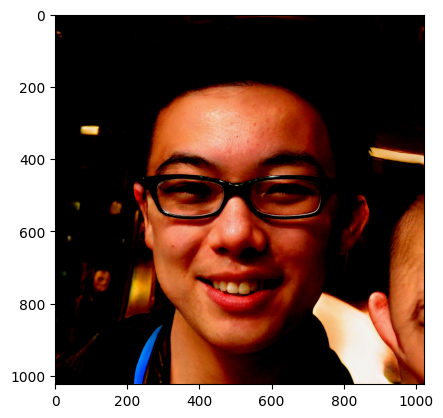

In [ ]:
# Сгенерируем изображение
latent_z = torch.randn(10000, 512, device=device) # Z noise
latent_z_generated = latent_z.mean(0, keepdim=True)

with torch.no_grad():
  target_img, _ = generator([latent_z_generated], input_is_latent=False)

# Визуализируйте изначальную картинку
target_img = target_img.squeeze(0).permute(1, 2, 0).cpu().numpy()
plt.imshow(target_img)
plt.show()

## Задача оптимизации

Теперь давайте подронее сформулируем задачу оптимизации.

Нам необходимо следующее:

- Отредактированное изображение соответствует текстовому запросу

- Сохраняет identity изначального человека.

Авторы предлагают следующий лосс для оптимизации:

$$\arg \min_{w \in W} D_{\text{CLIP}}(G(w), t) + \lambda_2 \|w - w_s\|_2 + \lambda_{\text{ID}} L_{\text{ID}}(w)
$$

Давайте разберёмся с каждой частью подробнее.

### CLIP loss

Начнём мы с CLIP loss.

 $D_{\text{CLIP}}$ — косинусное расстояние между эмбеддингами [CLIP](https://habr.com/ru/articles/539312/) для двух аргументов.

$$D_{\text{CLIP}}(G(w), t) = 1 - \frac{\langle E_{\text{CLIP}}(G(w)) \cdot E_{\text{CLIP}}(t) \rangle }{\|E_{\text{CLIP}}(G(w))\| \cdot \|E_{\text{CLIP}}(t)\|}$$


In [ ]:
import torch
import clip


class CLIPLoss(torch.nn.Module):
    """
    Этот класс определяет пользовательскую функцию потерь на основе CLIP (Contrastive Language–Image Pre-training).
    Он измеряет сходство между изображением и текстовым описанием.
    """

    def __init__(self, stylegan_size=1024):
        """
        Инициализирует класс CLIPLoss.

        Args:
            opts: Объект, содержащий различные параметры, включая размер изображения StyleGAN.
        """
        super(CLIPLoss, self).__init__()
        # Загружаем предварительно обученную модель CLIP и функцию предварительной обработки
        self.model, self.preprocess = clip.load("ViT-B/32", device="cuda")

        self.upsample = torch.nn.Upsample(scale_factor=7)
        self.avg_pool = torch.nn.AvgPool2d(kernel_size=stylegan_size // 32)

    def forward(self, image, text):
        """
        Вычисляет потери CLIP между изображением и текстом.

        Args:
            image: Входной тензор изображения.
            text: Тензор текстового описания.

        Returns:
            Значение потерь CLIP.
        """
        # Меняем размерность изображения для получения нужного разрешения для CLIP
        image = self.avg_pool(self.upsample(image))

        # Получаем эмбеддинги изображения и текста
        image_features = self.model.encode_image(image)
        text_features = self.model.encode_text(text)

        # Нормализуем эмбеддинги
        image_features = image_features / image_features.norm(dim=1, keepdim=True)
        text_features = text_features / text_features.norm(dim=1, keepdim=True)

        # Вычисляем косинусное сходство
        similarity = (image_features * text_features).sum(dim=1)

        # Преобразуем сходство в потери (чем больше сходство, тем меньше потери)
        loss = 1 - similarity

        return loss

In [ ]:
clip_loss = CLIPLoss()

100%|███████████████████████████████████████| 338M/338M [00:04<00:00, 71.6MiB/s]


### ID loss

Для сохранения identity человека использует специально предобученную модель [ArcFace](https://arxiv.org/abs/1801.07698), которая по фотографии вычисляет некоторые характерные для человека embedding вектора. Затем нам необходимо посчитать косинусное расстояние между ожидаемым embedding вектором и тем, что получается в процессе оптимизации:

$$ L_{\text{ID}}(w) = 1 - \langle R(G(w_s)), R(G(w)) \rangle $$

Обратите внимание, что здесь не используется дополнительная нормировка


Давайте подгрузим нашу модель и реализуем желаемую функцию потерь.


### Подгрузка модели

Далее у нас будет подгрузка самой модели, позаимствованная из репозитория [StyleCLIP](https://github.com/orpatashnik/StyleCLIP/blob/main/models/facial_recognition/helpers.py). Вы можете более подробно ознакомиться с кодом этой модели ниже, но мы не будем заострять на ней внимание.


In [ ]:
from torch.nn import Linear, Conv2d, BatchNorm1d, BatchNorm2d, PReLU, Dropout, Sequential, Module

"""
Modified Backbone implementation from [TreB1eN](https://github.com/TreB1eN/InsightFace_Pytorch)
"""
from collections import namedtuple
import torch
from torch.nn import Conv2d, BatchNorm2d, PReLU, ReLU, Sigmoid, MaxPool2d, AdaptiveAvgPool2d, Sequential, Module

"""
ArcFace implementation from [TreB1eN](https://github.com/TreB1eN/InsightFace_Pytorch)
"""


class Flatten(Module):
	def forward(self, input):
		return input.view(input.size(0), -1)


def l2_norm(input, axis=1):
	norm = torch.norm(input, 2, axis, True)
	output = torch.div(input, norm)
	return output


class Bottleneck(namedtuple('Block', ['in_channel', 'depth', 'stride'])):
	""" A named tuple describing a ResNet block. """


def get_block(in_channel, depth, num_units, stride=2):
	return [Bottleneck(in_channel, depth, stride)] + [Bottleneck(depth, depth, 1) for i in range(num_units - 1)]


def get_blocks(num_layers):
	if num_layers == 50:
		blocks = [
			get_block(in_channel=64, depth=64, num_units=3),
			get_block(in_channel=64, depth=128, num_units=4),
			get_block(in_channel=128, depth=256, num_units=14),
			get_block(in_channel=256, depth=512, num_units=3)
		]
	elif num_layers == 100:
		blocks = [
			get_block(in_channel=64, depth=64, num_units=3),
			get_block(in_channel=64, depth=128, num_units=13),
			get_block(in_channel=128, depth=256, num_units=30),
			get_block(in_channel=256, depth=512, num_units=3)
		]
	elif num_layers == 152:
		blocks = [
			get_block(in_channel=64, depth=64, num_units=3),
			get_block(in_channel=64, depth=128, num_units=8),
			get_block(in_channel=128, depth=256, num_units=36),
			get_block(in_channel=256, depth=512, num_units=3)
		]
	else:
		raise ValueError("Invalid number of layers: {}. Must be one of [50, 100, 152]".format(num_layers))
	return blocks


class SEModule(Module):
	def __init__(self, channels, reduction):
		super(SEModule, self).__init__()
		self.avg_pool = AdaptiveAvgPool2d(1)
		self.fc1 = Conv2d(channels, channels // reduction, kernel_size=1, padding=0, bias=False)
		self.relu = ReLU(inplace=True)
		self.fc2 = Conv2d(channels // reduction, channels, kernel_size=1, padding=0, bias=False)
		self.sigmoid = Sigmoid()

	def forward(self, x):
		module_input = x
		x = self.avg_pool(x)
		x = self.fc1(x)
		x = self.relu(x)
		x = self.fc2(x)
		x = self.sigmoid(x)
		return module_input * x


class bottleneck_IR(Module):
	def __init__(self, in_channel, depth, stride):
		super(bottleneck_IR, self).__init__()
		if in_channel == depth:
			self.shortcut_layer = MaxPool2d(1, stride)
		else:
			self.shortcut_layer = Sequential(
				Conv2d(in_channel, depth, (1, 1), stride, bias=False),
				BatchNorm2d(depth)
			)
		self.res_layer = Sequential(
			BatchNorm2d(in_channel),
			Conv2d(in_channel, depth, (3, 3), (1, 1), 1, bias=False), PReLU(depth),
			Conv2d(depth, depth, (3, 3), stride, 1, bias=False), BatchNorm2d(depth)
		)

	def forward(self, x):
		shortcut = self.shortcut_layer(x)
		res = self.res_layer(x)
		return res + shortcut


class bottleneck_IR_SE(Module):
	def __init__(self, in_channel, depth, stride):
		super(bottleneck_IR_SE, self).__init__()
		if in_channel == depth:
			self.shortcut_layer = MaxPool2d(1, stride)
		else:
			self.shortcut_layer = Sequential(
				Conv2d(in_channel, depth, (1, 1), stride, bias=False),
				BatchNorm2d(depth)
			)
		self.res_layer = Sequential(
			BatchNorm2d(in_channel),
			Conv2d(in_channel, depth, (3, 3), (1, 1), 1, bias=False),
			PReLU(depth),
			Conv2d(depth, depth, (3, 3), stride, 1, bias=False),
			BatchNorm2d(depth),
			SEModule(depth, 16)
		)

	def forward(self, x):
		shortcut = self.shortcut_layer(x)
		res = self.res_layer(x)
		return res + shortcut


class Backbone(Module):
	def __init__(self, input_size, num_layers, mode='ir', drop_ratio=0.4, affine=True):
		super(Backbone, self).__init__()
		assert input_size in [112, 224], "input_size should be 112 or 224"
		assert num_layers in [50, 100, 152], "num_layers should be 50, 100 or 152"
		assert mode in ['ir', 'ir_se'], "mode should be ir or ir_se"
		blocks = get_blocks(num_layers)
		if mode == 'ir':
			unit_module = bottleneck_IR
		elif mode == 'ir_se':
			unit_module = bottleneck_IR_SE
		self.input_layer = Sequential(Conv2d(3, 64, (3, 3), 1, 1, bias=False),
									  BatchNorm2d(64),
									  PReLU(64))
		if input_size == 112:
			self.output_layer = Sequential(BatchNorm2d(512),
			                               Dropout(drop_ratio),
			                               Flatten(),
			                               Linear(512 * 7 * 7, 512),
			                               BatchNorm1d(512, affine=affine))
		else:
			self.output_layer = Sequential(BatchNorm2d(512),
			                               Dropout(drop_ratio),
			                               Flatten(),
			                               Linear(512 * 14 * 14, 512),
			                               BatchNorm1d(512, affine=affine))

		modules = []
		for block in blocks:
			for bottleneck in block:
				modules.append(unit_module(bottleneck.in_channel,
										   bottleneck.depth,
										   bottleneck.stride))
		self.body = Sequential(*modules)

	def forward(self, x):
		x = self.input_layer(x)
		x = self.body(x)
		x = self.output_layer(x)
		return l2_norm(x)


def IR_50(input_size):
	"""Constructs a ir-50 model."""
	model = Backbone(input_size, num_layers=50, mode='ir', drop_ratio=0.4, affine=False)
	return model


def IR_101(input_size):
	"""Constructs a ir-101 model."""
	model = Backbone(input_size, num_layers=100, mode='ir', drop_ratio=0.4, affine=False)
	return model


def IR_152(input_size):
	"""Constructs a ir-152 model."""
	model = Backbone(input_size, num_layers=152, mode='ir', drop_ratio=0.4, affine=False)
	return model


def IR_SE_50(input_size):
	"""Constructs a ir_se-50 model."""
	model = Backbone(input_size, num_layers=50, mode='ir_se', drop_ratio=0.4, affine=False)
	return model


def IR_SE_101(input_size):
	"""Constructs a ir_se-101 model."""
	model = Backbone(input_size, num_layers=100, mode='ir_se', drop_ratio=0.4, affine=False)
	return model


def IR_SE_152(input_size):
	"""Constructs a ir_se-152 model."""
	model = Backbone(input_size, num_layers=152, mode='ir_se', drop_ratio=0.4, affine=False)
	return model

### ID loss

Теперь непосредственно реализуем нашу функцию потерь.

In [ ]:
import torch
from torch import nn


class IDLoss(nn.Module):
    def __init__(self, model_weights, device='cuda'):
        super(IDLoss, self).__init__()
        print('Loading ResNet ArcFace')
        self.facenet = Backbone(input_size=112, num_layers=50, drop_ratio=0.6, mode='ir_se')
        self.facenet.load_state_dict(torch.load(model_weights))
        self.pool = torch.nn.AdaptiveAvgPool2d((256, 256))
        self.face_pool = torch.nn.AdaptiveAvgPool2d((112, 112))
        self.facenet.eval()
        self.facenet.to(device)

    def extract_feats(self, x):
        if x.shape[2] != 256 or x.shape[3] != 256:
            x = self.pool(x)

        if x.shape[2] >= 223 and x.shape[3] >= 220:
            x = x[:, :, 35:223, 32:220]
        else:
            h, w = x.shape[2], x.shape[3]
            crop_size = min(h, w)
            start_h = (h - crop_size) // 2
            start_w = (w - crop_size) // 2
            x = x[:, :, start_h:start_h + crop_size, start_w:start_w + crop_size]

        x = self.face_pool(x)
        x_feats = self.facenet(x)
        return x_feats

    def forward(self, y_hat, y):
        with torch.no_grad():
            y_feats = self.extract_feats(y)  # Исходные фичи (без градиентов)
        y_hat_feats = self.extract_feats(y_hat)  # Фичи сгенерированного изображения

        # Нормализация векторов и косинусная потеря
        y_feats = F.normalize(y_feats, p=2, dim=1)
        y_hat_feats = F.normalize(y_hat_feats, p=2, dim=1)
        cos_sim = (y_feats * y_hat_feats).sum(dim=1)

        return (1 - cos_sim).mean()  # Усредненный loss

In [ ]:
# Загрузим нашу модель ArcFace
model_path = "/content/stylegan2-pytorch/model_ir_se50.pth"
id_loss_fn = IDLoss(model_path, device)

Loading ResNet ArcFace


## Инициализация латентного вектора и текстовой подсказки
Определим латентный вектор
𝑊
W для исходного изображения и преобразуем текстовую подсказку в вектор с помощью CLIP, что будет служить нашей целью для редактирования.

## Оптимизация для редактирования изображения
Реализуем оптимизацию, используя Adam. На каждом шаге обновляется латентный вектор $w \in W$ для минимизации потерь CLIP, пока результат не будет похож на текстовую подсказку.

Основной псевдокод оптимизации представлен ниже:

```python

for step in range(num_steps):  # <----------- итерируемся по датасету несколько раз
    torch.cuda.empty_cache() # <------------- очищаем кэш модели
    optimizer.zero_grad()  # <------------- обуляем градиенты модели
    image, _ = generator([latent], input_is_latent=True, randomize_noise=False)  # <------------- получаем картинку из StyleGAN-2
    loss = clip_loss + l2_lambda * l2_loss + id_lambda * id_loss
    loss.backward()  # <------------------- считаем градиенты
    optimizer.step()  # <------------------ делаем шаг градиентного спуска
    if convergence:  # <------------------- в случае сходимости выходим из цикла
        break
```

Где полная функция потерь считается по формуле:
$$\arg \min_{w \in W} D_{\text{CLIP}}(G(w), t) + \lambda_2 \|w - w_s\|_2 + \lambda_{\text{ID}} L_{\text{ID}}(w)
$$

Дополнительно сохраните значения лосс функций для дальнейшей визуализации.


In [ ]:
# Подготавливаем текстовый промпт для оптимизации, который будет направлять изменение изображения.
prompt = "a person with green hair"

# Токенизируем промпт с помощью CLIP tokenizer и перемещаем на устройство (CPU или GPU).
# clip.tokenize: функция из библиотеки CLIP для токенизации текста.
text_inputs = torch.cat([clip.tokenize(prompt)]).to(device)

In [ ]:
# Подготовим папку для сохранения результатов
import os
save_dir = "results"
os.makedirs(save_dir, exist_ok=True)

Работать предлагаем в пространстве $W$, давайте преобразуем наш вектор в styleSpace

In [ ]:
# Получаем w-вектор из z-вектора с помощью mapping network генератора.
with torch.no_grad():
  latent_w = generator.style(latent_z_generated)

latent = latent_w.detach().clone()
latent.requires_grad = True

In [ ]:
%matplotlib inline

In [ ]:
with torch.no_grad():
  target_img, _ = generator([latent_z_generated], input_is_latent=False)

In [ ]:
import torch.nn.functional as F

inversion_generated_z/Step [0/200], Loss: 0.83740234375


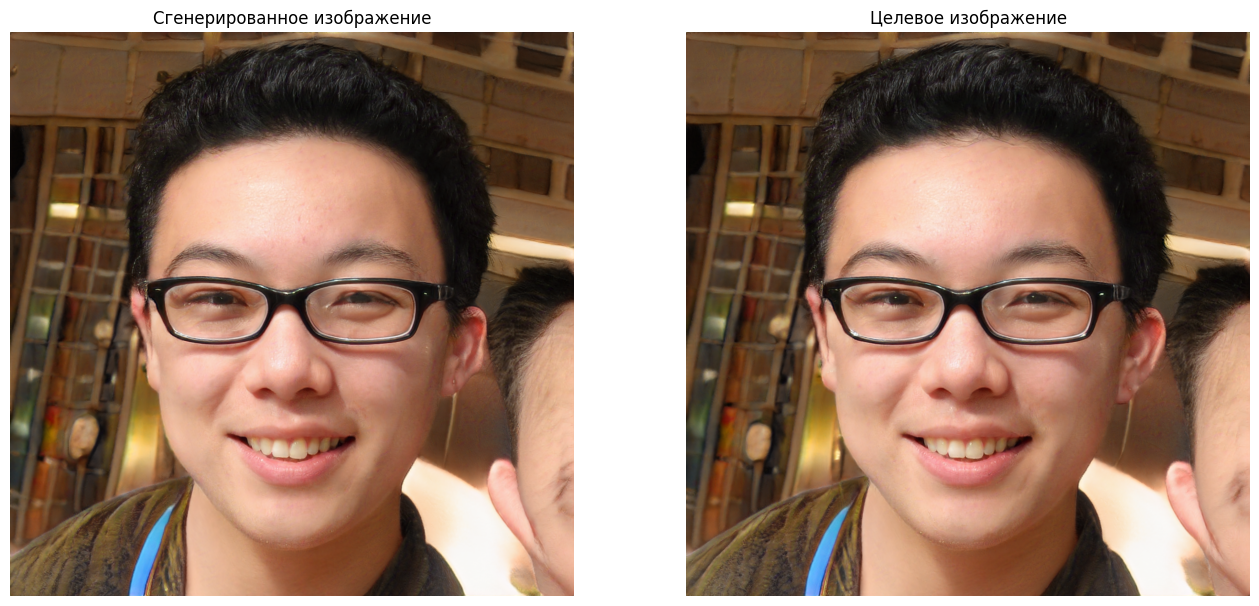

inversion_generated_z/Step [50/200], Loss: 0.7080078125


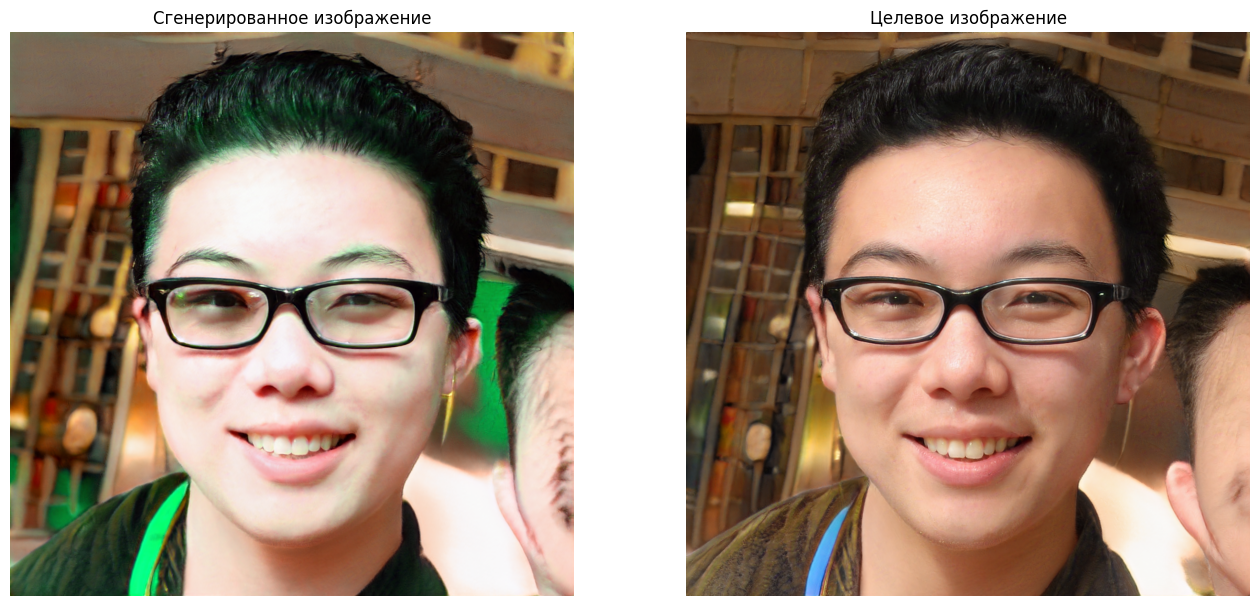

inversion_generated_z/Step [100/200], Loss: 0.6669921875


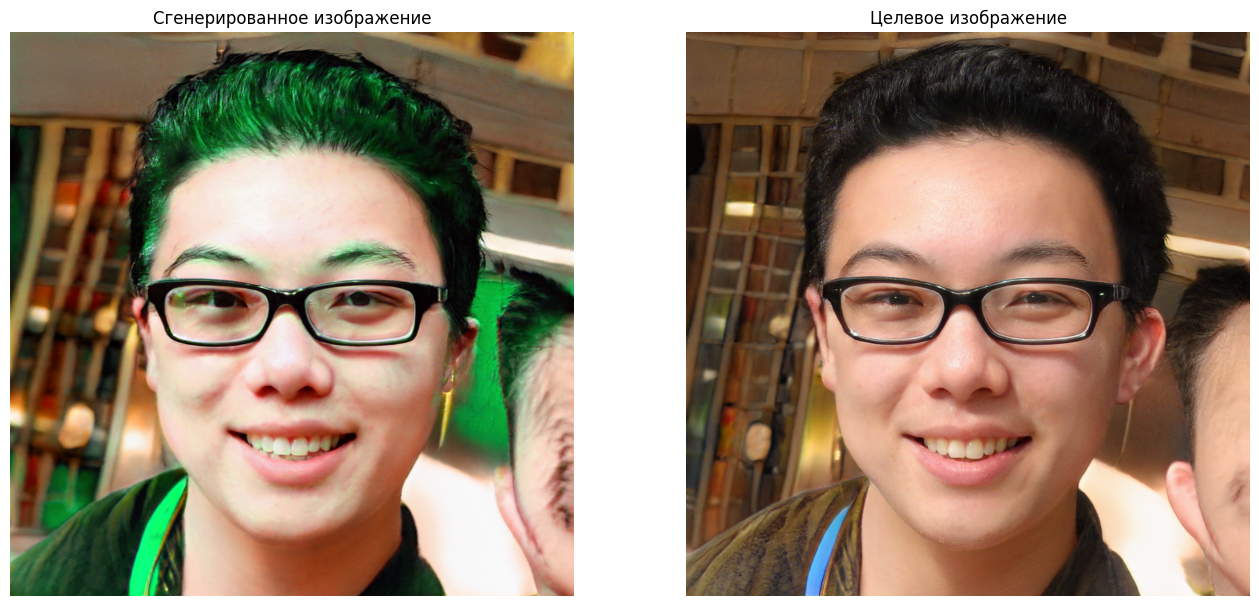

inversion_generated_z/Step [150/200], Loss: 0.65576171875


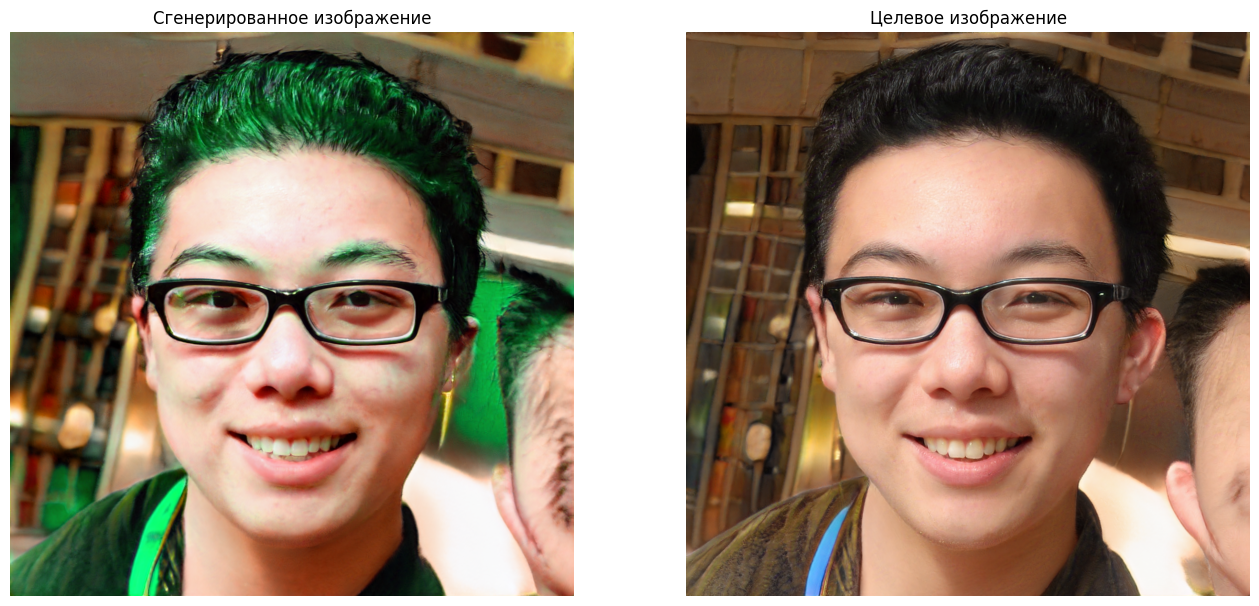

In [ ]:
# Оптимизация для редактирования с помощью CLIP
optimizer = torch.optim.Adam([latent], lr=0.01)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)  # Плавное снижение скорости обучения

num_steps = 200  # количество шагов оптимизации
l2_lambda = 0.006  # коэффициент для L2 регуляризации
id_lambda = 0.003  # коэффициент для identity loss

losses = {'id': [],
          'l2': [],
          'clip': [],
          'all': []
          }

for step in range(num_steps):
    torch.cuda.empty_cache()
    optimizer.zero_grad()

    img_gen, _ = generator([latent],  input_is_latent=True, randomize_noise=False)

    # Вычисляем потери
    # CLIP loss между сгенерированным изображением и текстовым описанием
    cl_loss = clip_loss(img_gen, text_inputs)

    # L2 регуляризация латентного кода
    l2_loss = torch.norm(latent, 2) * l2_lambda

    # Identity loss для сохранения идентичности
    current_id_loss = id_loss_fn(img_gen, target_img) * id_lambda

    # Общий loss
    total_loss = cl_loss + l2_loss + current_id_loss

    # Обратное распространение ошибки
    total_loss.backward()
    optimizer.step()
    scheduler.step()

    # Сохраняем значения потерь
    losses['clip'].append(cl_loss.item())
    losses['l2'].append(l2_loss.item())
    losses['id'].append(current_id_loss.item())
    losses['all'].append(total_loss.item())

    # Визуализация и вывод потерь
    if step % 50 == 0:
        print(f"inversion_generated_z/Step [{step}/{num_steps}], Loss: {losses['all'][-1]}")
        fig, axs = plt.subplots(1, 2, figsize=(16, 32))

        axs[0].imshow((img_gen.cpu().detach()[0].clip(-1,1).permute(1, 2, 0) + 1) / 2)
        axs[0].set_title("Сгенерированное изображение")
        axs[0].axis('off')

        axs[1].imshow((target_img.cpu().detach()[0].clip(-1,1).permute(1, 2, 0) + 1) / 2)
        axs[1].set_title("Целевое изображение")
        axs[1].axis('off')
        plt.show()

Визуализируйте лоссы в зависимости от step

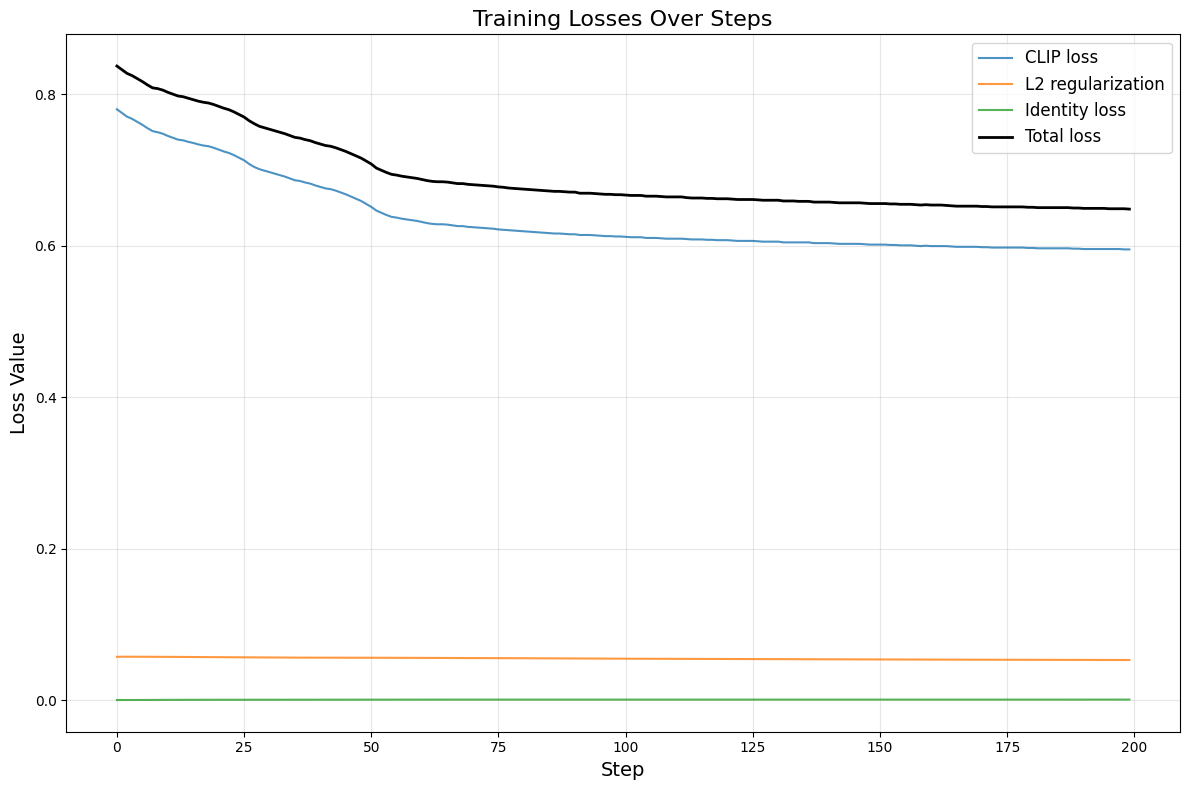

In [ ]:
import matplotlib.pyplot as plt

def plot_losses(losses, num_steps):
    plt.figure(figsize=(12, 8))

    plt.plot(range(num_steps), losses['clip'], label='CLIP loss', alpha=0.8)
    plt.plot(range(num_steps), losses['l2'], label='L2 regularization', alpha=0.8)
    plt.plot(range(num_steps), losses['id'], label='Identity loss', alpha=0.8)
    plt.plot(range(num_steps), losses['all'], label='Total loss', linewidth=2, color='black')

    plt.title('Training Losses Over Steps', fontsize=16)
    plt.xlabel('Step', fontsize=14)
    plt.ylabel('Loss Value', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

plot_losses(losses, num_steps)

Сохряним результаты!

In [ ]:
import os

filename = prompt

# Save the latents to a .pt file.
latent_path = os.path.join(save_dir, filename + ".pt")
torch.save(latent, latent_path)

# Save the image to a .png file.
image_path = os.path.join(save_dir, filename + ".png")
save_image(img_gen, image_path)


print(f"Ваше изображение и латенты успешно сохранены в папке {save_dir}")

Ваше изображение и латенты успешно сохранены в папке results


### Вывооды

Напишите ваши выводы, что получилось, что нет, почему получилось, почему нет.

Получилось неплохо сохранить identity человека после подбора гиперпараметров,identity loss очень близок к нулю. CLIP лосс также показал неплохой результат на 200 степах.
В итоге получилось оптимизировать латентный вектор под текстовый запрос и сгенерировать изображение с зелеными волосами